<a href="https://colab.research.google.com/github/alexgil3/A-neural-network-performance-analysis-with-three-different-model-structures/blob/main/TFG_Recurrent_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from timeit import default_timer as timer
import os
import pandas as pd

from datetime import datetime
from timeit import default_timer as timer


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
#CPU and GPU flag managemment
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0" # write -1 to use CPU or write 0 to use GPU
import tensorflow as tf

In [ ]:
#CPU and GPU identification
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16988764302323709880
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2742593813973635578
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [ ]:
#Tensorflow version used
tf.__version__

'2.4.1'

In [ ]:
#Load data. Source:https://es.investing.com/equities/apple-computer-inc-historical-data
train_data = pd.read_csv('E:/Alejandro/Uni/4º/TFG/TensorFlow course/Data sets/Apple 1.csv')
test_data = pd.read_csv('E:/Alejandro/Uni/4º/TFG/TensorFlow course/Data sets/Apple 2.csv')

In [ ]:
train_data.head()

,Month/Day,Year,Price,Open,High,Low,Vol.,Change %
0,Jan 03,2007,2.99,3.08,3.09,2.92,1.25B,-1.32%
1,Jan 04,2007,3.06,3.00,3.07,2.99,856.13M,2.34%
2,Jan 05,2007,3.04,3.06,3.08,3.01,835.40M,-0.65%
3,Jan 08,2007,3.05,3.07,3.09,3.05,797.73M,0.33%
4,Jan 09,2007,3.31,3.09,3.32,3.04,3.35B,8.52%


In [ ]:
train_data['Date'] = train_data['Month/Day'].map(str) + " " + train_data['Year'].map(str)
train_data.drop(['Month/Day','Year'],axis=1)
train_data = train_data[["Date", "High", "Low","Open", "Vol.","Change %","Price"]]


test_data['Date'] = test_data['Month/Day'].map(str) + " " + test_data['Year'].map(str)
test_data.drop(['Month/Day','Year'],axis=1)
test_data = test_data[["Date", "High", "Low","Open", "Vol.","Change %","Price"]]

In [ ]:
train_data.head()

,Date,High,Low,Open,Vol.,Change %,Price
0,Jan 03 2007,3.09,2.92,3.08,1.25B,-1.32%,2.99
1,Jan 04 2007,3.07,2.99,3.00,856.13M,2.34%,3.06
2,Jan 05 2007,3.08,3.01,3.06,835.40M,-0.65%,3.04
3,Jan 08 2007,3.09,3.05,3.07,797.73M,0.33%,3.05
4,Jan 09 2007,3.32,3.04,3.09,3.35B,8.52%,3.31


Text(0, 0.5, 'Price')

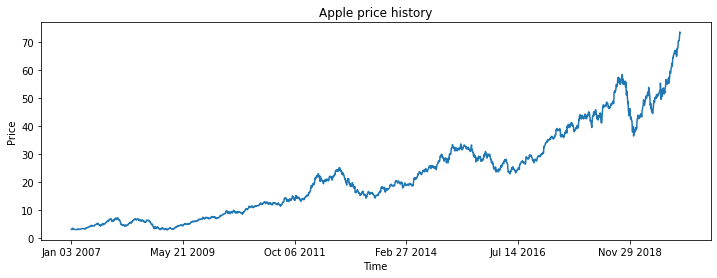

In [ ]:
y = train_data['High']
x = np.arange(y.shape[0])
my_xticks = train_data['Date']

frequency = 600



plt.figure(figsize=(12,4))
plt.plot(x,y)
plt.xticks(x[::frequency], my_xticks[::frequency])


plt.title('Apple price history')
plt.xlabel('Time')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

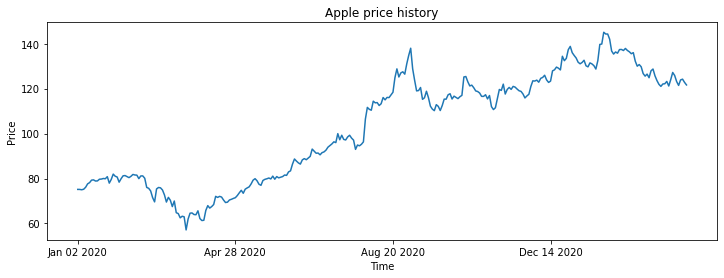

In [ ]:
y1 = test_data['High']
x1 = np.arange(y1.shape[0])
my_xticks = test_data['Date']

frequency2 = 80



plt.figure(figsize=(12,4))
plt.plot(x1,y1)
plt.xticks(x1[::frequency2], my_xticks[::frequency2])


plt.title('Apple price history')
plt.xlabel('Time')
plt.ylabel('Price')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

train_data[['High']] = scaler.fit_transform(train_data[['High']])
test_data[['High']] = scaler.fit_transform(test_data[['High']])

In [ ]:
train_data.head()

,Date,High,Low,Open,Vol.,Change %,Price
0,Jan 03 2007,0.002268,2.92,3.08,1.25B,-1.32%,2.99
1,Jan 04 2007,0.001984,2.99,3.00,856.13M,2.34%,3.06
2,Jan 05 2007,0.002126,3.01,3.06,835.40M,-0.65%,3.04
3,Jan 08 2007,0.002268,3.05,3.07,797.73M,0.33%,3.05
4,Jan 09 2007,0.005527,3.04,3.09,3.35B,8.52%,3.31


In [ ]:
#Focus on the 'High' comlumn
training_set = train_data.iloc[:,1:2].values
test_set = test_data.iloc[:,1:2].values
len(test_set)

310

In [ ]:
X_train = []
y_train = []

for i in range(60,len(train_data.index)):
    X_train.append(training_set[i-60:i,0])
    y_train.append(training_set[i,0])


X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(3213, 60)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
X_train.shape

(3213, 60, 1)

### **LSTM Model**

In [ ]:
# The LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

### **GRU Model**

In [ ]:
# The GRU architecture
model_2 = Sequential()
# First GRU layer with Dropout regularisation
model_2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_2.add(Dropout(0.2))
# Second GRU layer
model_2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_2.add(Dropout(0.2))
# Third GRU layer
model_2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_2.add(Dropout(0.2))
# Fourth GRU layer
model_2.add(GRU(units=50, activation='tanh'))
model_2.add(Dropout(0.2))
# The output layer
model_2.add(Dense(units=1))

In [ ]:
#Save model imports
import h5py
from keras.models import load_model

#LSTM
save = model.save('E:/Alejandro/Uni/4º/TFG/TensorFlow course/LSTM_model.h5')
del model
model = load_model('E:/Alejandro/Uni/4º/TFG/TensorFlow course/LSTM_model.h5')

#GRU
save_2 = model.save('E:/Alejandro/Uni/4º/TFG/TensorFlow course/GRU_model.h5')
del model_2
model_2 = load_model('E:/Alejandro/Uni/4º/TFG/TensorFlow course/GRU_model.h5')

### **Batch train**

In [ ]:
#Train the model
def train_batch(num_iter):

  num_batch = 8
  results_time = np.zeros(num_iter)
  results_accuracy = np.zeros(num_iter)
  results_accuracy_val = np.zeros(num_iter)
  num_epochs = 8


  for i in range(num_iter):
    
    #Load
    model = load_model('E:/Alejandro/Uni/4º/TFG/TensorFlow course/LSTM_model.h5')
    model.compile(optimizer='rmsprop',loss='mean_squared_error')

    #Train
    print("Traing the model....batch_size =",num_batch)
    start = timer()
    train = model.fit(X_train,y_train,epochs=num_epochs,batch_size = num_batch)
    end = timer()

    #Delete
    del model

    #Iterate   
    num_batch+=8

    results_time[i] = end-start
    #results_accuracy[i] = train.history['accuracy'][num_epochs-1]
    #results_accuracy_val[i] = train.history['val_accuracy'][num_epochs-1]

  return results_time


In [ ]:
#Train the model
def train_batch_2(num_iter):

  num_batch = 8
  results_time = np.zeros(num_iter)
  results_accuracy = np.zeros(num_iter)
  results_accuracy_val = np.zeros(num_iter)
  num_epochs = 8


  for i in range(num_iter):
    
    #Load
    model_2 = load_model('E:/Alejandro/Uni/4º/TFG/TensorFlow course/GRU_model.h5')
    #model_2.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    model_2.compile(optimizer='rmsprop',loss='mean_squared_error')

    #Train
    print("Traing the model....batch_size =",num_batch)
    start = timer()
    train = model_2.fit(X_train,y_train,epochs=num_epochs,batch_size = num_batch)
    end = timer()

    #Delete
    del model_2

    #Iterate   
    num_batch+=8

    results_time[i] = end-start
    #results_accuracy[i] = train.history['accuracy'][num_epochs-1]
    #results_accuracy_val[i] = train.history['val_accuracy'][num_epochs-1]

  return results_time


In [ ]:
# LSTM train
num_iter = 32
results_time = train_batch(num_iter)

Traing the model....batch_size = 8
Epoch 1/8
402/402 [==============================] - 15s 17ms/step - loss: 0.0105
Epoch 2/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0028
Epoch 3/8
402/402 [==============================] - 6s 16ms/step - loss: 0.0021
Epoch 4/8
402/402 [==============================] - 6s 16ms/step - loss: 0.0016
Epoch 5/8
402/402 [==============================] - 6s 16ms/step - loss: 0.0016
Epoch 6/8
402/402 [==============================] - 6s 16ms/step - loss: 0.0013
Epoch 7/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0012
Epoch 8/8
402/402 [==============================] - 8s 20ms/step - loss: 0.0013
Traing the model....batch_size = 16
Epoch 1/8
201/201 [==============================] - 11s 16ms/step - loss: 0.0149
Epoch 2/8
201/201 [==============================] - 3s 16ms/step - loss: 0.0032
Epoch 3/8
201/201 [==============================] - 3s 16ms/step - loss: 0.0029
Epoch 4/8
201/201 [=================

In [ ]:
# GRU train
results_time_2 = train_batch_2(num_iter)

Traing the model....batch_size = 8
Epoch 1/8
402/402 [==============================] - 13s 16ms/step - loss: 0.0089
Epoch 2/8
402/402 [==============================] - 7s 18ms/step - loss: 0.0026
Epoch 3/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0022
Epoch 4/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0018
Epoch 5/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0016
Epoch 6/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0015
Epoch 7/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0011
Epoch 8/8
402/402 [==============================] - 7s 17ms/step - loss: 0.0013
Traing the model....batch_size = 16
Epoch 1/8
201/201 [==============================] - 10s 17ms/step - loss: 0.0141
Epoch 2/8
201/201 [==============================] - 4s 18ms/step - loss: 0.0036
Epoch 3/8
201/201 [==============================] - 4s 18ms/step - loss: 0.0026
Epoch 4/8
201/201 [=================

### **Plot batch size**

In [ ]:

x = np.linspace(16,16*num_iter,num_iter)

#LSTM
y1 = results_time

#GRU
y1_GRU = results_time_2
#y2_GRU = results_accuracy_2
#y3_GRU = results_accuracy_val_2

Text(0, 0.5, 'Time')

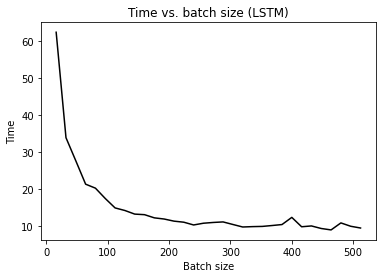

In [ ]:
#LSTM time vs. batch size
plt.plot(x,y1,'k')
#plt.plot(x_pow,y_pow,'ro')
plt.title('Time vs. batch size (LSTM)')
plt.xlabel('Batch size')
plt.ylabel('Time')

Text(0, 0.5, 'Time')

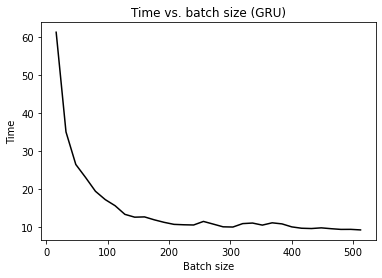

In [ ]:
#GRU time vs. batch size
plt.plot(x,y1_GRU,'k')
#plt.plot(x_pow,y_pow,'ro')
plt.title('Time vs. batch size (GRU)')
plt.xlabel('Batch size')
plt.ylabel('Time')

### **Predictions**

In [ ]:
# Fitting to the training set
del model
#Load
model = load_model('E:/Alejandro/Uni/4º/TFG/TensorFlow course/LSTM_model.h5')
model.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])
train = model.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
101/101 [==============================] - 9s 18ms/step - loss: 0.0196 - accuracy: 6.3532e-04
Epoch 2/50
101/101 [==============================] - 2s 17ms/step - loss: 0.0048 - accuracy: 2.6434e-04
Epoch 3/50
101/101 [==============================] - 2s 17ms/step - loss: 0.0031 - accuracy: 0.0010
Epoch 4/50
101/101 [==============================] - 2s 17ms/step - loss: 0.0030 - accuracy: 6.8358e-04
Epoch 5/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0023 - accuracy: 5.2224e-04
Epoch 6/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0023 - accuracy: 2.3817e-04
Epoch 7/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0019 - accuracy: 3.9148e-04
Epoch 8/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0017 - accuracy: 6.7212e-04
Epoch 9/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0016 - accuracy: 0.0012
Epoch 10/50
101/101 [==============================] - 2s 18ms/

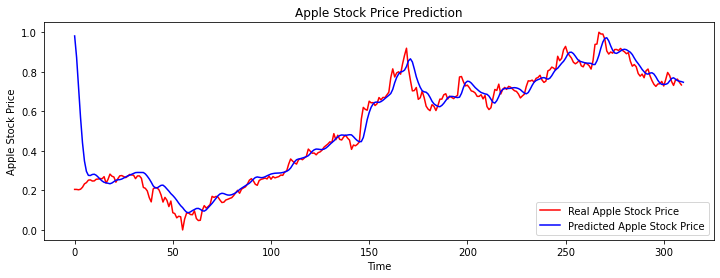

In [ ]:
#Get test inputs
total_data = pd.concat((train_data['High'],test_data['High']),axis=0)
inputs = total_data[len(total_data)-len(test_set) - 60:].values

#Reshape and transforn
inputs = inputs.reshape(-1,1)
inputs  = scaler.fit_transform(inputs)

#Create structure reshaped with test inputs
X_test = []
for i in range(60,len(test_data.index)+61):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)


X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#Predict stock price
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

plt.figure(figsize=(12,4))
plt.plot(test_set, color='red',label='Real Apple Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [ ]:
test_set

array([[0.20495624],
       [0.20484256],
       [0.20313743],
       [0.20575196],
       [0.21586905],
       [0.23292031],
       [0.23928612],
       [0.25179038],
       [0.25315448],
       [0.24735705],
       [0.24792543],
       [0.25645106],
       [0.25724679],
       [0.26008867],
       [0.25883824],
       [0.2695237 ],
       [0.23667159],
       [0.25554166],
       [0.28236899],
       [0.27168353],
       [0.2677049 ],
       [0.24155962],
       [0.25906559],
       [0.27361601],
       [0.27498011],
       [0.26975105],
       [0.264522  ],
       [0.27111515],
       [0.28066386],
       [0.27782198],
       [0.27713993],
       [0.25940662],
       [0.27304763],
       [0.27327498],
       [0.26133909],
       [0.21507332],
       [0.21041264],
       [0.19722633],
       [0.16346482],
       [0.14186655],
       [0.20734341],
       [0.21461862],
       [0.21291349],
       [0.20200068],
       [0.17721951],
       [0.14095714],
       [0.16471524],
       [0.149

### Sequence

In [ ]:
# Preparing sequence data
initial_sequence = X_train[X_train.shape[0]-61,:]
sequence = []
for i in range(309):
   
  new_prediction = model.predict( initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
  initial_sequence[1:]
  initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
  sequence.append(new_prediction)
sequence = scaler.inverse_transform(np.array(sequence).reshape(309,1))

    
plt.figure(figsize=(12,4))
plt.plot(test_set, color='red',label='Real apple Stock Price')
plt.plot(sequence, color='blue',label='Predicted  sequence')
plt.title('Apple Stock Sequence Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()  

### **Train activation functions**

In [ ]:
def create_model_GRU_af(num_layers, activation_function):
  # The GRU architecture
  model = Sequential()

  for i in range(num_layers-1):
    # GRU layer with Dropout regularisation
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation=activation_function))
    model.add(Dropout(0.2))
  
  # With return sequences = false, the layer will only return the last hidden state
  model.add(GRU(units=50, activation=activation_function))
  model.add(Dropout(0.2))

  # The output layer
  model.add(Dense(units=1))


  return model

In [ ]:
def create_model_LSTM_af(num_layers, activation_function):
  # The LSTM architecture
  model = Sequential()

  # First LSTM layer with Dropout regularisation 
  # It must be specified the “length” of the input,the number of steps/words in each sample
  model.add(LSTM(units=50,activation = activation_function, return_sequences=True, input_shape=(X_train.shape[1],1)))
  model.add(Dropout(0.2))

  for i in range(num_layers-2):
    # Second LSTM layer
    model.add(LSTM(units=50,activation = activation_function, return_sequences=True))
    model.add(Dropout(0.2))

  # Fourth LSTM layer
  model.add(LSTM(units=50, activation = activation_function))
  model.add(Dropout(0.2))

  # The output layer
  model.add(Dense(units=1))

  return model

In [ ]:
#Train the model
def train_GRU(model):

  num_batch = 256
  num_epochs = 20
  
  model.compile(optimizer='rmsprop',loss='mean_squared_error',metrics = 'accuracy')

  #Train
  print("Traing the model....batch_size =",num_batch)
  start = timer()
  train = model.fit(X_train,y_train,epochs=num_epochs,batch_size = num_batch)
  end = timer()

  #results_accuracy[i] = train.history['accuracy'][num_epochs-1]
  #results_accuracy_val[i] = train.history['val_accuracy'][num_epochs-1]

  return end-start

In [ ]:
#Train the model
def train_LSTM(model):

  num_batch = 256
  num_epochs = 20
  
  model.compile(optimizer='rmsprop',loss='mean_squared_error',metrics = 'accuracy')

  #Train
  print("Traing the model....batch_size =",num_batch)
  start = timer()
  train = model.fit(X_train,y_train,epochs=num_epochs,batch_size = num_batch)
  end = timer()

  #results_accuracy[i] = train.history['accuracy'][num_epochs-1]
  #results_accuracy_val[i] = train.history['val_accuracy'][num_epochs-1]

  return end-start

In [ ]:
model_tan_GRU = create_model_GRU_af(2, 'tanh')
model_soft_GRU = create_model_GRU_af(2, 'softmax')
model_relu_GRU = create_model_GRU_af(2, 'relu')
model_sigmoid_GRU = create_model_GRU_af(2, 'sigmoid')

In [ ]:
time_tan_GRU = train_GRU(model_tan_GRU)
time_soft_GRU = train_GRU(model_soft_GRU)
time_relu_GRU = train_GRU(model_relu_GRU)
time_sigmoid_GRU = train_GRU(model_sigmoid_GRU)

In [ ]:
loss_relu = model_relu.history.history['loss']
loss_soft = model_soft.history.history['loss']
loss_sigmoid = model_sigmoid.history.history['loss']
loss_tan = model_tan.history.history['loss']

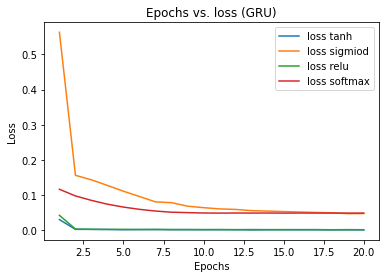

In [ ]:
x = np.arange(1,21,1)
plt.plot(x,loss_tan, label = 'loss tanh')
plt.plot(x,loss_sigmoid, label = 'loss sigmiod')
plt.plot(x,loss_relu, label = 'loss relu')
plt.plot(x,loss_soft, label = 'loss softmax')

plt.title('Epochs vs. loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model_tan_LSTM = create_model_LSTM_af(2, 'tanh')
model_soft_LSTM = create_model_LSTM_af(2, 'softmax')
model_relu_LSTM = create_model_LSTM_af(2, 'relu')
model_sigmoid_LSTM = create_model_LSTM_af(2, 'sigmoid')

In [ ]:
time_tan_LSTM = train_LSTM(model_tan_LSTM)
time_relu_LSTM = train_LSTM(model_relu_LSTM)
time_soft_LSTM = train_LSTM(model_soft_LSTM)
time_sigmoid_LSTM = train_LSTM(model_sigmoid_LSTM)

Traing the model....batch_size = 256
Epoch 1/20
13/13 [==============================] - 4s 15ms/step - loss: 0.0615 - accuracy: 1.1218e-04
Epoch 2/20
13/13 [==============================] - 0s 16ms/step - loss: 0.0048 - accuracy: 8.5802e-04
Epoch 3/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 1.3754e-04
Epoch 4/20
13/13 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 9.0452e-04
Epoch 5/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0047 - accuracy: 7.6501e-04
Epoch 6/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0032 - accuracy: 2.7994e-04
Epoch 7/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 9.7803e-04
Epoch 8/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 6.4377e-04
Epoch 9/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 8.5802e-04
Epoch 10/20
13/13 [=================

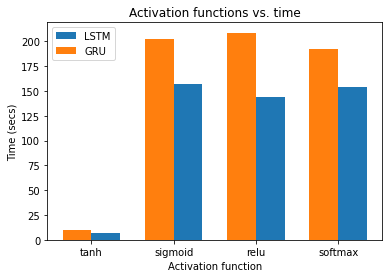

In [ ]:
data_LSTM = (time_tan_LSTM, time_sigmoid_LSTM, time_relu_LSTM, time_soft_LSTM)
data_GRU = (time_tan_GRU, time_sigmoid_GRU, time_relu_GRU, time_soft_GRU)

ind = np.arange(4)
width = 0.35

plt.bar(ind + width, data_LSTM,width, label = 'LSTM')
plt.bar(ind, data_GRU, width, label = 'GRU')


plt.title('Activation functions vs. time')
plt.xlabel('Activation function')
plt.ylabel('Time (secs)')

plt.legend(loc='best')
plt.xticks(ind + width / 2, ('tanh', 'sigmoid', 'relu', 'softmax'))
plt.show()

In [ ]:
loss_relu_LSTM = model_relu.history.history['loss']
loss_soft_LSTM = model_soft.history.history['loss']
loss_sigmoid_LSTM = model_sigmoid.history.history['loss']
loss_tan_LSTM = model_tan.history.history['loss']

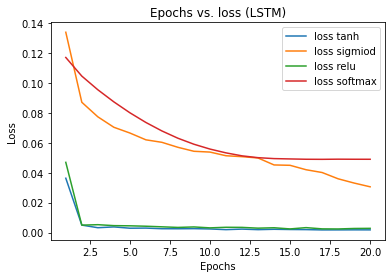

In [ ]:
x = np.arange(1,21,1)
plt.plot(x,loss_tan_LSTM, label = 'loss tanh')
plt.plot(x,loss_sigmoid_LSTM, label = 'loss sigmiod')
plt.plot(x,loss_relu_LSTM, label = 'loss relu')
plt.plot(x,loss_soft_LSTM, label = 'loss softmax')

plt.title('Epochs vs. loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### **Train activation functions**

In [ ]:
def create_model_GRU_dropout(num_layers, dropout):
  # The GRU architecture
  model = Sequential()

  for i in range(num_layers-1):
    # GRU layer with Dropout regularisation
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    model.add(Dropout(dropout))
  
  # With return sequences = false, the layer will only return the last hidden state
  model.add(GRU(units=50, activation='tanh'))
  model.add(Dropout(dropout))

  # The output layer
  model.add(Dense(units=1))


  return model

In [ ]:
def create_model_LSTM_dropout(num_layers,dropout):
  # The LSTM architecture
  model = Sequential()

  # First LSTM layer with Dropout regularisation 
  # It must be specified the “length” of the input,the number of steps/words in each sample
  model.add(LSTM(units=50,activation = 'tanh', return_sequences=True, input_shape=(X_train.shape[1],1)))
  model.add(Dropout(dropout))

  for i in range(num_layers-2):
    # Second LSTM layer
    model.add(LSTM(units=50,activation = 'tanh', return_sequences=True))
    model.add(Dropout(dropout))

  # Fourth LSTM layer
  model.add(LSTM(units=50, activation = 'tanh'))
  model.add(Dropout(dropout))

  # The output layer
  model.add(Dense(units=1))

  return model

In [ ]:
time_d_GRU_array = np.zeros(11)
time_d_LSTM_array = np.zeros(11)
loss_d_GRU_array = np.zeros(11)
loss_d_LSTM_array = np.zeros(11)
max_GRU = np.zeros(11)
max_LSTM = np.zeros(11)
min_GRU = np.zeros(11)
min_LSTM = np.zeros(11)
for j in range (10):
  av = 0
  for i in range(11):

    if(i == 10):
       i = 9.9
    print('training model dropout:', i/10)
    model_d_GRU =  create_model_GRU_dropout(2,i/10)
    model_d_LSTM = create_model_LSTM_dropout(2,i/10)
    time_d_GRU = train_GRU(model_d_GRU)
    time_d_LSTM = train_LSTM(model_d_LSTM)
    if(i == 9.9):
      i = 10
    time_d_GRU_array[i] +=  time_d_GRU
    time_d_LSTM_array[i] += time_d_LSTM
    print(time_d_GRU)
    if j == 0:
      min_GRU[i] = time_d_GRU
      min_LSTM[i] = time_d_LSTM
      max_GRU[i] = time_d_GRU
      max_LSTM[i] = time_d_LSTM

    if time_d_GRU < min_GRU[i]:
      min_GRU[i] = time_d_GRU
    if time_d_LSTM < min_LSTM[i]:
      min_LSTM[i] = time_d_LSTM
    
    if time_d_GRU > max_GRU[i]:
      max_GRU[i] = time_d_GRU
    if time_d_LSTM > min_LSTM[i]:
      max_LSTM[i] = time_d_LSTM
  
    loss_d_GRU_array[i] = model_d_GRU.history.history['loss'][3]
    loss_d_LSTM_array[i] = model_d_LSTM.history.history['loss'][3]
    del model_d_GRU
    del model_d_LSTM

time_d_GRU_array /= 10
time_d_LSTM_array /= 10
  

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 20/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 4.5344e-04
Traing the model....batch_size = 256
Epoch 1/20
13/13 [==============================] - 4s 14ms/step - loss: 0.0418 - accuracy: 8.9057e-04
Epoch 2/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0085 - accuracy: 3.6630e-04
Epoch 3/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0071 - accuracy: 1.6544e-04
Epoch 4/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0075 - accuracy: 3.3884e-04
Epoch 5/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0066 - accuracy: 4.6649e-04
Epoch 6/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0057 - accuracy: 3.1768e-04
Epoch 7/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 6.0225e-04
Epoch 8/20
13/13 [==============================] - 0s 14ms/step - loss: 0.00

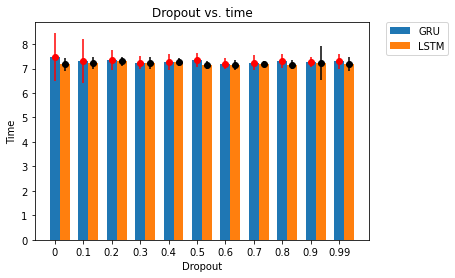

In [ ]:
x = np.arange(0,11,1)
labels  = (0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99)

width = 0.35
err1 = ((max_GRU[0]-min_GRU[0])/2,(max_GRU[1]-min_GRU[1])/2,(max_GRU[2]-min_GRU[2])/2,(max_GRU[3]-min_GRU[3])/2,(max_GRU[4]-min_GRU[4])/2,(max_GRU[5]-min_GRU[5])/2,
(max_GRU[6]-min_GRU[6])/2,(max_GRU[7]-min_GRU[7])/2,(max_GRU[8]-min_GRU[8])/2,(max_GRU[9]-min_GRU[9])/2,(max_GRU[10]-min_GRU[10])/2 )


err2 = ((max_LSTM[0]-min_LSTM[0])/2,(max_LSTM[1]-min_LSTM[1])/2,(max_LSTM[2]-min_LSTM[2])/2,(max_LSTM[3]-min_LSTM[3])/2,(max_LSTM[4]-min_LSTM[4])/2,(max_LSTM[5]-min_LSTM[5])/2,
        (max_LSTM[6]-min_LSTM[6])/2,(max_LSTM[7]-min_LSTM[7])/2,(max_LSTM[8]-min_LSTM[8])/2,(max_LSTM[9]-min_LSTM[9])/2,(max_LSTM[10]-min_LSTM[10])/2 )

#plt.plot(x,time_d_GRU_array, label = 'GRU time')
#plt.plot(x,time_d_LSTM_array, label = 'LSTM time')

plt.bar(x, time_d_GRU_array, width, label = 'GRU')
plt.errorbar(x, time_d_GRU_array,yerr=err1, fmt="o", color="r")

plt.bar(x + width, time_d_LSTM_array, width, label = 'LSTM')
plt.errorbar(x + width, time_d_LSTM_array,yerr=err2, fmt="o", color="k")

plt.xticks(x, labels)
plt.title('Dropout vs. time')
plt.xlabel('Dropout')
plt.ylabel('Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
max_GRU

array([ 9.8059755, 13.1521933, 13.1216351, 12.6721918, 12.5893637,
       11.2943641, 15.0110589, 11.1878808, 12.8684086, 12.6526169,
       12.103872 ])

In [ ]:
min_GRU

array([6.3508767, 6.3394042, 6.2300691, 6.3352839, 6.3542239, 6.3158696,
       6.3610879, 6.3792833, 6.35141  , 6.4035329, 6.3365811])

In [ ]:
a = max_GRU-min_GRU
a

array([3.4550988, 6.8127891, 6.891566 , 6.3369079, 6.2351398, 4.9784945,
       8.649971 , 4.8085975, 6.5169986, 6.249084 , 5.7672909])

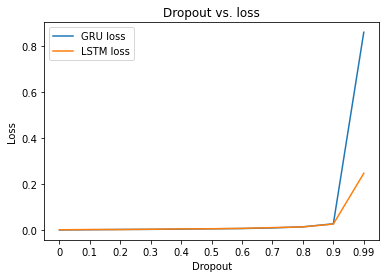

In [ ]:
x = np.arange(0,11,1)
labels  = (0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99)
plt.plot(x,loss_d_GRU_array, label = 'GRU loss')
plt.plot(x,loss_d_LSTM_array, label = 'LSTM loss')

plt.xticks(x, labels)
plt.title('Dropout vs. loss')
plt.xlabel('Dropout')
plt.ylabel('Loss')
plt.legend()

### **CPU vs GPU**

In [ ]:
time_GRU = 0
time_LSTM = 0
av_time_GRU = 0
av_time_LSTM = 0
results_time = np.zeros(20)
results_time2 = np.zeros(20)
for i in range(20):
  time_GRU = 0
  time_LSTM = 0
  print('training model GPU iteration:', i)
  model_GRU =  create_model_GRU_af(2,'tanh')
  model_LSTM = create_model_LSTM_af(2,'tanh')
  time_GRU = train_GRU(model_GRU)
  time_LSTM = train_LSTM(model_LSTM)
  av_time_GRU += time_GRU
  av_time_LSTM += time_LSTM
  results_time[i] = time_GRU
  results_time2[i] = time_LSTM
  del model_GRU
  del model_LSTM

time_GRU /=20
time_LSTM /= 20

training model GPU iteration: 0
Traing the model....batch_size = 256
Epoch 1/20
13/13 [==============================] - 6s 107ms/step - loss: 0.0552 - accuracy: 9.7803e-04
Epoch 2/20
13/13 [==============================] - 1s 109ms/step - loss: 0.0028 - accuracy: 9.5478e-04
Epoch 3/20
13/13 [==============================] - 1s 96ms/step - loss: 0.0023 - accuracy: 1.1218e-04
Epoch 4/20
13/13 [==============================] - 1s 98ms/step - loss: 0.0030 - accuracy: 9.6032e-04
Epoch 5/20
13/13 [==============================] - 1s 96ms/step - loss: 0.0022 - accuracy: 0.0015
Epoch 6/20
13/13 [==============================] - 1s 100ms/step - loss: 0.0028 - accuracy: 3.7349e-04
Epoch 7/20
13/13 [==============================] - 1s 100ms/step - loss: 0.0027 - accuracy: 2.5457e-04
Epoch 8/20
13/13 [==============================] - 1s 86ms/step - loss: 0.0018 - accuracy: 5.5575e-04
Epoch 9/20
13/13 [==============================] - 1s 95ms/step - loss: 0.0019 - accuracy: 0.0011
Epoch 10

In [ ]:
time_GRU


2.378102220000005

In [ ]:
time_LSTM

2.302736945000004

In [ ]:
max = np.nanmax(results_time,axis=0)
min = np.nanmin(results_time,axis=0)
res = max - min
res

21.073182700000025

In [ ]:
max2 = np.nanmax(results_time2,axis=0)
min2 = np.nanmin(results_time2,axis=0)
res2 = max2 - min2
res2

17.460510000000113

In [ ]:
results_time

array([29.4745609, 28.796802 , 36.2097858, 36.3056159, 44.2802123,
       46.6477023, 49.4612151, 49.8699847, 46.0792969, 48.3505419,
       48.6679926, 49.6454145, 46.5514281, 46.095515 , 45.7259857,
       46.0566088, 48.2967908, 44.3030317, 46.0110321, 47.5620444])

In [ ]:
results_time2

array([33.2316077, 32.7941942, 38.9533794, 33.1811856, 47.800831 ,
       43.010037 , 41.0173259, 47.242182 , 41.6711725, 39.0852793,
       43.4322906, 47.6174058, 40.9945634, 49.272445 , 47.7181386,
       49.9851977, 50.2547042, 44.1349595, 35.608797 , 46.0547389])

In [ ]:
import statistics as s

In [ ]:
av_GRU = s.mean(results_time)
av_LSTM = s.mean(results_time2)

In [ ]:
av_GRU

44.21957807500001

In [ ]:
av_LSTM

42.65302176499999

In [ ]:
max2 = np.nanmax(results_time2,axis=0)
min2 = np.nanmin(results_time2,axis=0)
res2 = max - min
res2

21.073182700000025

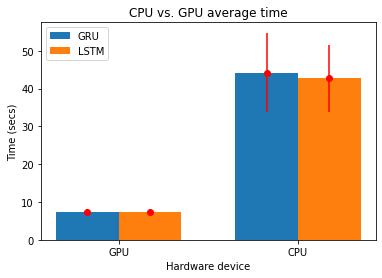

In [ ]:
data_GRU = (7.40,44.219)
data_LSTM = (7.22,42.65)
error1 = (1.329/2,21.07/2)
error2 = (1.98/2,17.460/2)

ind = np.arange(2)
width = 0.35

plt.bar(ind, data_GRU, width, label = 'GRU')
plt.errorbar(ind, data_GRU,yerr=error1, fmt="o", color="r")
plt.bar(ind + width, data_LSTM,width, label = 'LSTM')
plt.errorbar(ind + width, data_LSTM,yerr=error2, fmt="o", color="r")

plt.title('CPU vs. GPU average time')
plt.xlabel('Hardware device')
plt.ylabel('Time (secs)')

plt.legend(loc='upper left')
plt.xticks(ind+width/2, ('GPU','CPU'))
plt.show()

### **Train number of neurons**


In [ ]:
def create_model_GRU_neuron(num_layers, num_neurons):
  # The GRU architecture
  model = Sequential()

  for i in range(num_layers-1):
    # GRU layer with Dropout regularisation
    model.add(GRU(units=num_neurons, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
  
  # With return sequences = false, the layer will only return the last hidden state
  model.add(GRU(units=num_neurons, activation='tanh'))
  model.add(Dropout(0.2))

  # The output layer
  model.add(Dense(units=1))

  return model

In [ ]:
def create_model_LSTM_neuron(num_layers,num_neurons):
  # The LSTM architecture
  model = Sequential()

  # First LSTM layer with Dropout regularisation 
  # It must be specified the “length” of the input,the number of steps/words in each sample
  model.add(LSTM(units=num_neurons,activation = 'tanh', return_sequences=True, input_shape=(X_train.shape[1],1)))
  model.add(Dropout(0.2))

  for i in range(num_layers-2):
    # Second LSTM layer
    model.add(LSTM(units=num_neurons,activation = 'tanh', return_sequences=True))
    model.add(Dropout(0.2))

  # Fourth LSTM layer
  model.add(LSTM(units=num_neurons, activation = 'tanh'))
  model.add(Dropout(0.2))

  # The output layer
  model.add(Dense(units=1))

  return model

In [ ]:
time_GRU_array = np.zeros(21)
time_LSTM_array = np.zeros(21)
loss_GRU_array = np.zeros(21)
loss_LSTM_array = np.zeros(21)
num_neurons = 5

for i in range(1, 21):
  
  print('training model neurons:',num_neurons)
  model_GRU =  create_model_GRU_neuron(2,num_neurons)
  model_LSTM = create_model_LSTM_neuron(2,num_neurons)
  time_GRU = train_GRU(model_GRU)
  time_LSTM = train_LSTM(model_LSTM)
  
  time_GRU_array[i] = time_GRU
  time_LSTM_array[i] = time_LSTM

  loss_GRU_array[i] = model_GRU.history.history['loss'][5]
  loss_LSTM_array[i] = model_LSTM.history.history['loss'][5]
  num_neurons+=5
  del model_GRU
  del model_LSTM

training model neurons: 5
Traing the model....batch_size = 256
Epoch 1/20
13/13 [==============================] - 5s 13ms/step - loss: 0.1275 - accuracy: 6.7714e-05
Epoch 2/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0745 - accuracy: 3.2903e-04
Epoch 3/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0521 - accuracy: 6.7714e-05
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0374 - accuracy: 6.3130e-04
Epoch 5/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0319 - accuracy: 1.2098e-04
Epoch 6/20
13/13 [==============================] - 0s 16ms/step - loss: 0.0253 - accuracy: 7.6501e-04
Epoch 7/20
13/13 [==============================] - 0s 17ms/step - loss: 0.0204 - accuracy: 8.2081e-04
Epoch 8/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0143 - accuracy: 7.9756e-04
Epoch 9/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0111 - accuracy: 4.9179e-04
Epoch 10/2

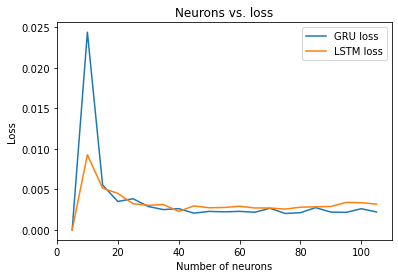

In [ ]:
x = np.arange(5,5*22,5)

plt.plot(x,loss_GRU_array, label = 'GRU loss')
plt.plot(x,loss_LSTM_array, label = 'LSTM loss')

plt.title('Neurons vs. loss')
plt.xlabel('Number of neurons')
plt.ylabel('Loss')
plt.legend()

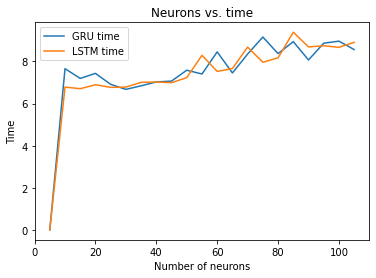

In [ ]:
x = np.arange(5,5*22,5)

plt.plot(x,time_GRU_array, label = 'GRU time')
plt.plot(x,time_LSTM_array, label = 'LSTM time')

plt.title('Neurons vs. time')
plt.xlabel('Number of neurons')
plt.ylabel('Time')
plt.legend()

In [ ]:
#Train the model
def train_LSTM_loss(model, loss):

  num_batch = 256
  num_epochs = 20
  
  model.compile(optimizer='rmsprop',loss=loss,metrics = 'accuracy')

  #Train
  print("Traing the model....batch_size =",num_batch)
  start = timer()
  train = model.fit(X_train,y_train,epochs=num_epochs,batch_size = num_batch)
  end = timer()

  #results_accuracy[i] = train.history['accuracy'][num_epochs-1]
  #results_accuracy_val[i] = train.history['val_accuracy'][num_epochs-1]

  return end-start

In [ ]:
#Train the model
def train_GRU_loss(model,loss):

  num_batch = 256
  num_epochs = 20
  
  model.compile(optimizer='rmsprop',loss=loss,metrics = 'accuracy')

  #Train
  print("Traing the model....batch_size =",num_batch)
  start = timer()
  train = model.fit(X_train,y_train,epochs=num_epochs,batch_size = num_batch)
  end = timer()

  #results_accuracy[i] = train.history['accuracy'][num_epochs-1]
  #results_accuracy_val[i] = train.history['val_accuracy'][num_epochs-1]

  return end-start

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [ ]:
model_mse = create_model_LSTM_neuron(2, 20)
model_mae = create_model_LSTM_neuron(2, 20)
model_rmse = create_model_LSTM_neuron(2, 20)
model_huber = create_model_LSTM_neuron(2, 20)

time_mse_LSTM = train_LSTM_loss(model_mse,'mean_squared_error')
time_mae_LSTM = train_LSTM_loss(model_mae,'mean_absolute_error')
time_rmse_LSTM = train_LSTM_loss(model_rmse,root_mean_squared_error)
time_huber_LSTM = train_LSTM_loss(model_huber,'huber')

loss_mse_LSTM = model_mse.history.history['loss']
loss_mae_LSTM = model_mae.history.history['loss']
loss_rmse_LSTM = model_rmse.history.history['loss']
loss_huber_LSTM = model_huber.history.history['loss']

del model_mse 
del model_mae
del model_rmse
del model_huber 

Traing the model....batch_size = 256
Epoch 1/20
13/13 [==============================] - 4s 16ms/step - loss: 0.0581 - accuracy: 1.8686e-04
Epoch 2/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0064 - accuracy: 0.0011
Epoch 3/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0053 - accuracy: 6.7865e-04
Epoch 4/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0045 - accuracy: 2.5457e-04
Epoch 5/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 3.9420e-04
Epoch 6/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 2.7994e-04
Epoch 7/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 1.3543e-04
Epoch 8/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0033 - accuracy: 5.5575e-04
Epoch 9/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0028 - accuracy: 1.8616e-04
Epoch 10/20
13/13 [=====================

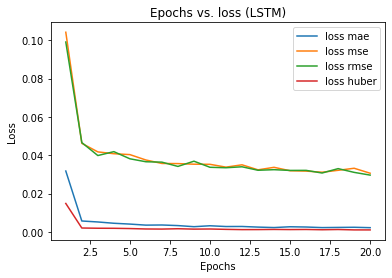

In [ ]:
x = np.arange(1,21,1)
plt.plot(x,loss_mse_LSTM, label = 'loss mae')
plt.plot(x,loss_mae_LSTM, label = 'loss mse')
plt.plot(x,loss_rmse_LSTM, label = 'loss rmse')
plt.plot(x,loss_huber_LSTM, label = 'loss huber')

plt.title('Epochs vs. loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

No handles with labels found to put in legend.


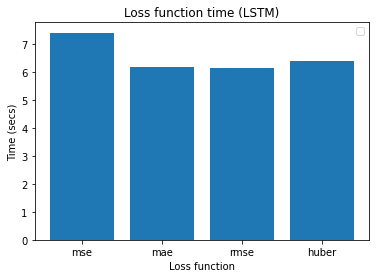

In [ ]:
data = (time_mse_LSTM,time_mae_LSTM,time_rmse_LSTM,time_huber_LSTM)


ind = np.arange(4)

plt.bar(ind, data)

plt.title('Loss function time (LSTM)')
plt.xlabel('Loss function')
plt.ylabel('Time (secs)')
plt.xticks(ind,('mse','mae','rmse','huber'))
plt.legend(loc='best')
plt.show()

In [ ]:
model_mse = create_model_GRU_neuron(2, 20)
model_mae = create_model_GRU_neuron(2, 20)
model_rmse = create_model_GRU_neuron(2, 20)
model_huber = create_model_GRU_neuron(2, 20)

time_mse_LSTM = train_LSTM_loss(model_mse,'mean_squared_error')
time_mae_LSTM = train_LSTM_loss(model_mae,'mean_absolute_error')
time_rmse_LSTM = train_LSTM_loss(model_rmse,root_mean_squared_error)
time_huber_LSTM = train_LSTM_loss(model_huber,'huber')

loss_mse_LSTM = model_mse.history.history['loss']
loss_mae_LSTM = model_mae.history.history['loss']
loss_rmse_LSTM = model_rmse.history.history['loss']
loss_huber_LSTM = model_huber.history.history['loss']

del model_mse 
del model_mae
del model_rmse
del model_huber 

Traing the model....batch_size = 256
Epoch 1/20
13/13 [==============================] - 4s 10ms/step - loss: 0.0738 - accuracy: 2.1970e-04
Epoch 2/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0098 - accuracy: 5.5950e-04
Epoch 3/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0046 - accuracy: 4.6008e-04
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0047 - accuracy: 2.9443e-04
Epoch 5/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0035 - accuracy: 5.8564e-04
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0038 - accuracy: 7.8328e-04
Epoch 7/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0033 - accuracy: 2.9443e-04
Epoch 8/20
13/13 [==============================] - 0s 17ms/step - loss: 0.0028 - accuracy: 4.8101e-04
Epoch 9/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0032 - accuracy: 5.5950e-04
Epoch 10/20
13/13 [=================

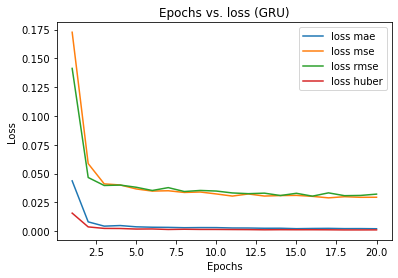

In [ ]:
x = np.arange(1,21,1)
plt.plot(x,loss_mse_LSTM, label = 'loss mae')
plt.plot(x,loss_mae_LSTM, label = 'loss mse')
plt.plot(x,loss_rmse_LSTM, label = 'loss rmse')
plt.plot(x,loss_huber_LSTM, label = 'loss huber')

plt.title('Epochs vs. loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

No handles with labels found to put in legend.


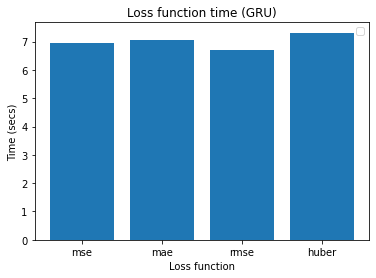

In [ ]:
data = (time_mse_LSTM,time_mae_LSTM,time_rmse_LSTM,time_huber_LSTM)


ind = np.arange(4)

plt.bar(ind, data)

plt.title('Loss function time (GRU)')
plt.xlabel('Loss function')
plt.ylabel('Time (secs)')
plt.xticks(ind,('mse','mae','rmse','huber'))
plt.legend(loc='best')
plt.show()